In [31]:

import importlib.resources
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from collections import Counter
import random


In [42]:
IMAGE_FOLDER_PATH = "../data/train_cleaned_color_resized"

In [43]:
# Character count
Counter(len(n.split("-")[0]) for n in os.listdir(IMAGE_FOLDER_PATH))

Counter({4: 1629, 6: 1608, 7: 1576, 8: 1548, 5: 1482})

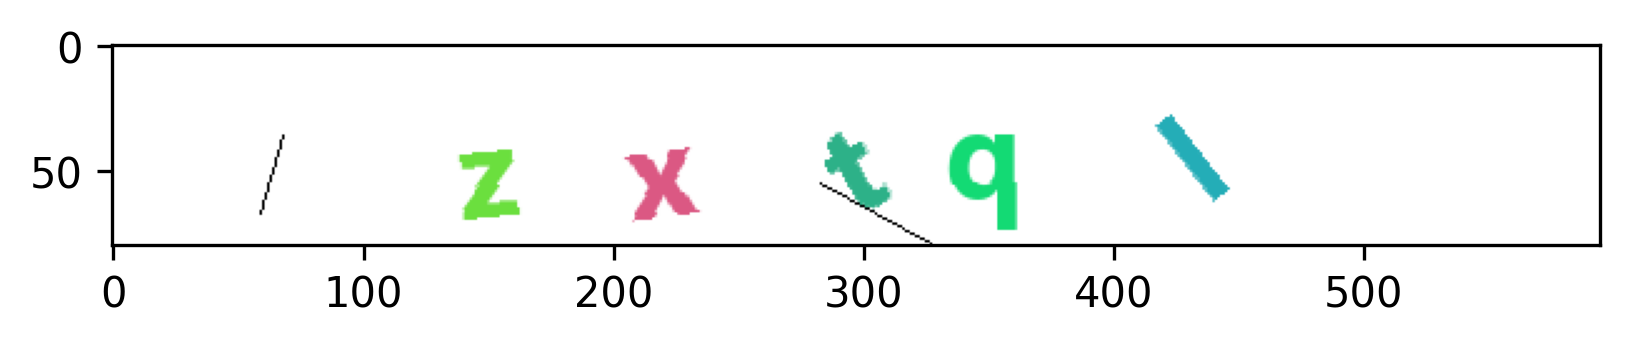

In [44]:
# Read the image
img = cv2.imread("../data/main/zxtql-0.png")
plt.imshow(img)




(79, 729, 3)


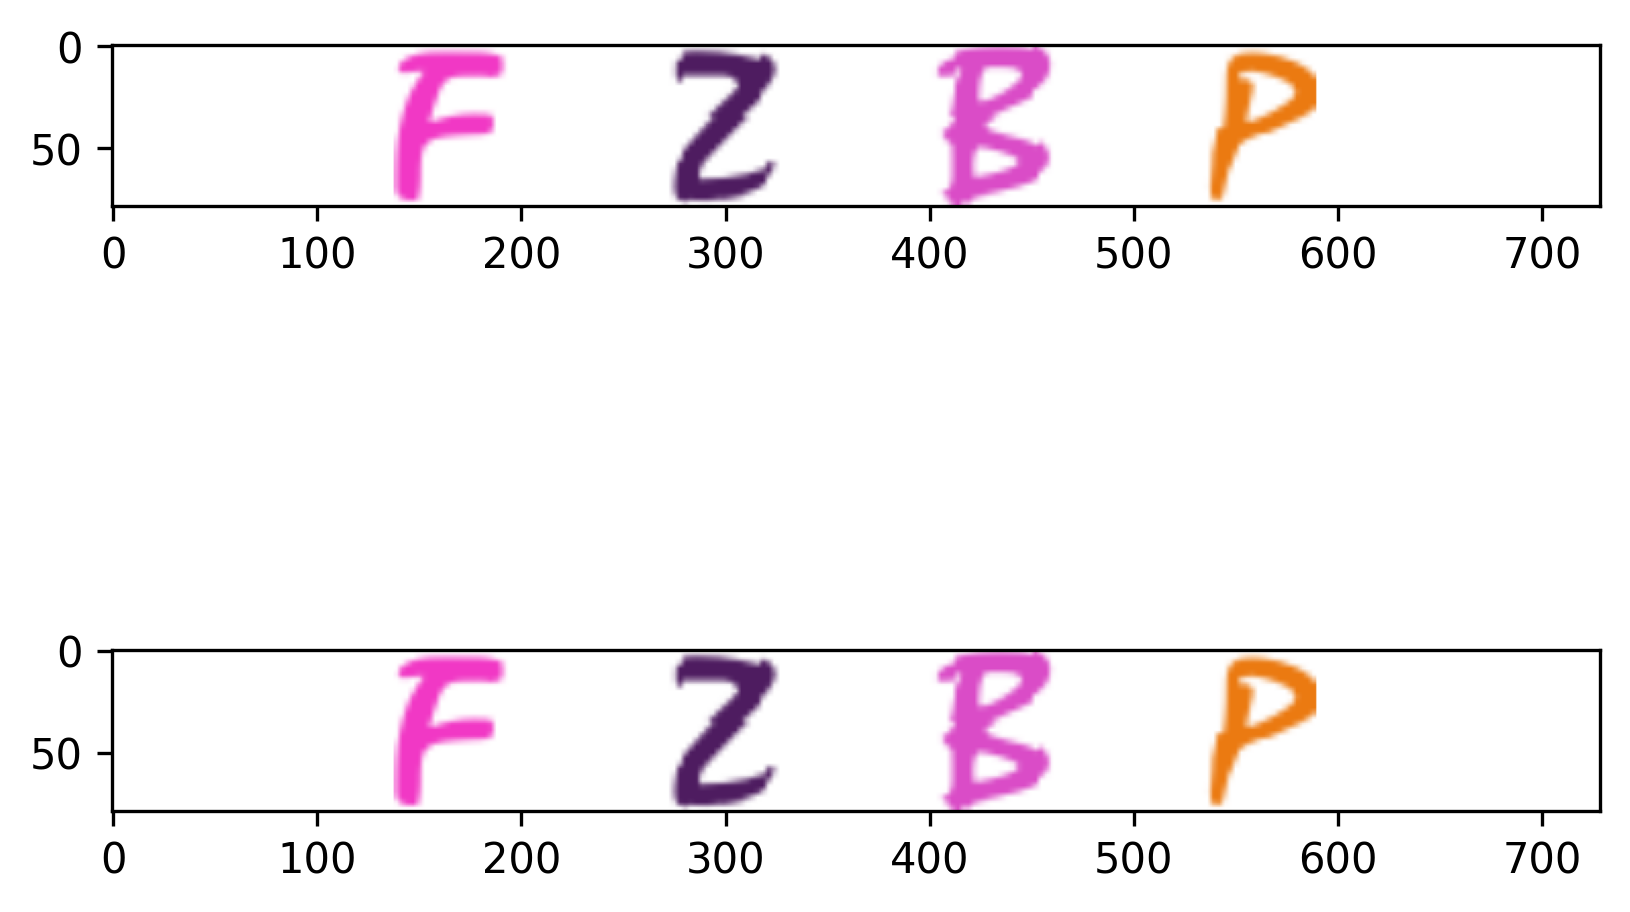

In [45]:
# Data cleaning: black line removal
colors = set()

def fetch_random_image():
    return random.choice(os.listdir(IMAGE_FOLDER_PATH))

def get_pixel(img, i, j):
    if i < 0 or j < 0 or i >= img.shape[0] or j >= img.shape[1]:
        return None
    return img[i][j]

def read_image(image_name):
    return cv2.imread(f"{IMAGE_FOLDER_PATH}/{image_name}")

def test_image(img):
    img = img.copy()
    max_colors = 10
    counter = Counter()
    for row in img:
        for pixel in row:
            counter[str(pixel)] += 1

    accepted_colours = [color for (color, _) in counter.most_common(max_colors + 2)]
    for i, row in enumerate(img):
        for j, pixel in enumerate(row):
            if str(pixel) == "[0 0 0]":
                # grab from surroundings:
                surrounding_pixels = [get_pixel(img, i + x, j + y) for x in range(-1, 2) for y in range(-1, 2) if x != 0 or y != 0 and str(pixel) in accepted_colours]
                fill = Counter(map(str, surrounding_pixels)).most_common(1)[0][0]
                fill_pixels = list(map(int, fill[1:-1].split()))
                # print(fill_pixels)
                for k in range(3):
                    img[i][j][k] = fill_pixels[k]

    return img

def test_image(img):
    img = img.copy()
    print(img.shape)

    # Flatten image for faster counting
    flat_pixels = img.reshape(-1, 3)

    # Count unique colors
    unique, counts = np.unique(flat_pixels, axis=0, return_counts=True)
    max_colors = 10

    # Get most common colors (excluding black [0, 0, 0])
    most_common_colors = unique[np.argsort(-counts)][:max_colors + 2]
    most_common_colors = [color for color in most_common_colors if not np.array_equal(color, [0, 0, 0])]

    # Identify black pixels
    black_mask = (img == [0, 0, 0]).all(axis=-1)

    # Process black pixels
    if np.any(black_mask):
        padded_img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT)

        # Iterate over black pixels only
        black_indices = np.argwhere(black_mask)

        for x, y in black_indices:
            # Extract 3x3 neighborhood
            neighborhood = padded_img[x:x + 3, y:y + 3].reshape(-1, 3)

            # Filter neighborhood with most common colors
            valid_neighbors = [tuple(pixel) for pixel in neighborhood if tuple(pixel) in map(tuple, most_common_colors)]

            if valid_neighbors:
                # Find most common color in the neighborhood
                fill_pixel = Counter(valid_neighbors).most_common(1)[0][0]
                img[x, y] = fill_pixel


    return img

# test_image("zxtql-0.png")
random_image_name = fetch_random_image()
random_image = read_image(random_image_name)
plt.subplot(211); plt.imshow(random_image)
plt.subplot(212); plt.imshow(test_image(random_image))

(80, 515, 3)
ikni4lb-0.png
(80, 515, 3)


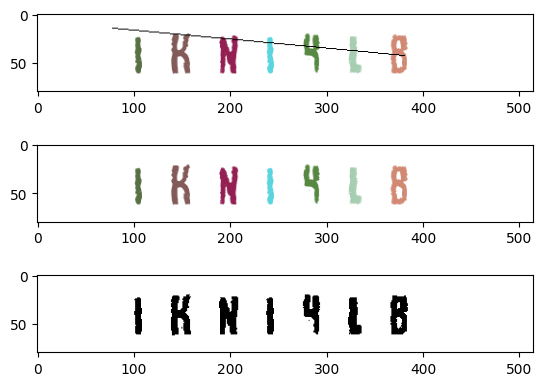

In [6]:
# Preprocessing: Color things black
def color_letters_black(img):
    img = img.copy()

    for i, row in enumerate(img):
        for j, pixel in enumerate(row):
            if not (pixel == [255, 255, 255]).all():
                img[i][j] = [0, 0, 0]
            else:
                img[i][j] = [255, 255, 255]

    return img

random_image_name = fetch_random_image()
random_image = read_image(random_image_name)
cleaned_lines = test_image(random_image)
black_letters = color_letters_black(cleaned_lines)

print(random_image_name)
plt.subplot(311); plt.imshow(random_image)
plt.subplot(312); plt.imshow(test_image(random_image))
plt.subplot(313); plt.imshow(black_letters)



p4oj4-0.png
(79, 729, 3)
close threshold 8
not close [243 224 222] [235 250 235] 47
not close [227 229 240] [243 224 222] 39
not close [235 192 252] [227 229 240] 57
not close [250 229 252] [235 192 252] 52
5
[2, 69, 85, 142, array([235, 250, 235], dtype=int32)]
[5, 78, 213, 256, array([243, 224, 222], dtype=int32)]
[11, 76, 345, 405, array([227, 229, 240], dtype=int32)]
[0, 78, 462, 515, array([235, 192, 252], dtype=int32)]
[9, 78, 584, 644, array([250, 229, 252], dtype=int32)]
(79, 729, 3)


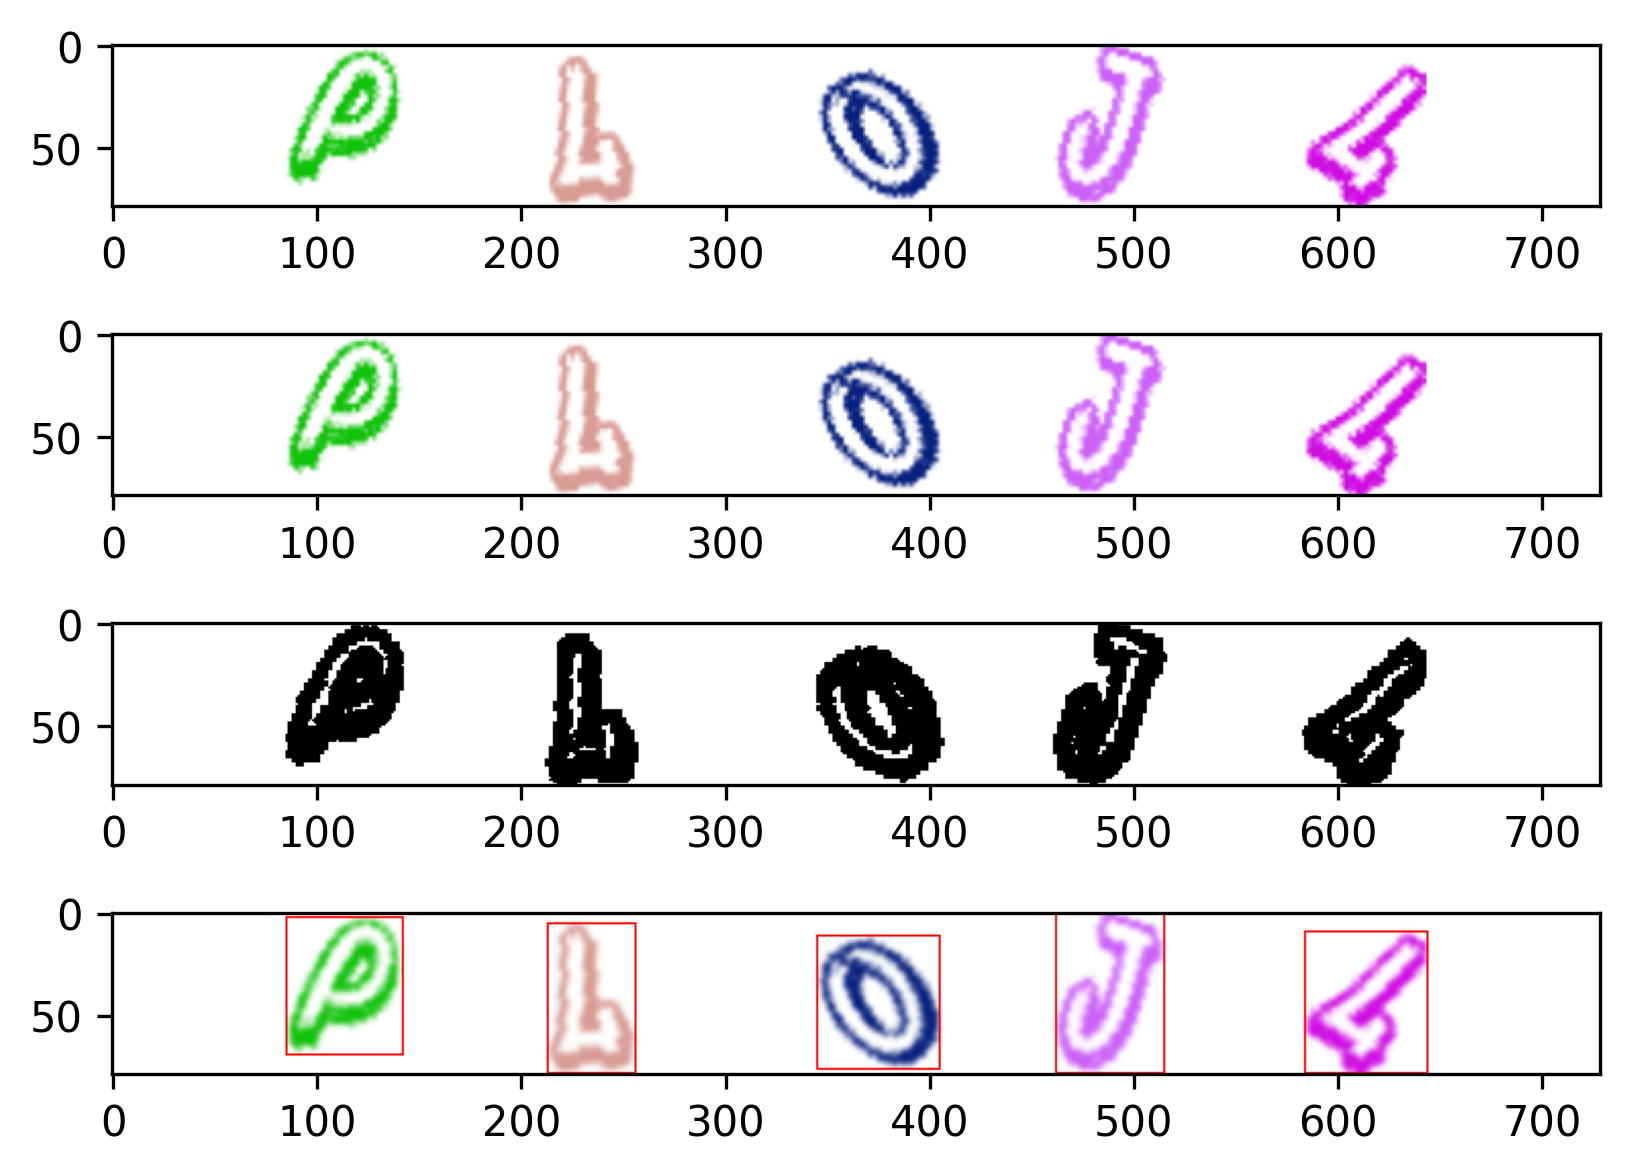

[2, 69, 85, 142, array([235, 250, 235], dtype=int32)]
[5, 78, 213, 256, array([243, 224, 222], dtype=int32)]
[11, 76, 345, 405, array([227, 229, 240], dtype=int32)]
[0, 78, 462, 515, array([235, 192, 252], dtype=int32)]
[9, 78, 584, 644, array([250, 229, 252], dtype=int32)]


In [ ]:

def merge_boxes(box1, box2):
    return [min(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), max(box1[3], box2[3]), box1[4]]

def is_surrounded_horizontally(box1, box2, atol=10)-> bool:
    """return box1 horizontally is inside box2"""
    return box1[2] >= box2[2] - atol and box1[3] <= box2[3] + atol

def is_tiny_box(box):
    return (abs(box[1] - box[0]) * abs(box[3] - box[2])) < 80

def generate_random_color():
    return [random.randint(0, 255) for _ in range(3)]

def partition_box(box, n=2):
    print(type(box[3]))
    print(box[3], box[2], n, (box[3] - box[2]) // n)
    part_length = int((box[3] - box[2]) // n)
    print(part_length)
    return [[box[0], box[1], box[2] + i * part_length, box[2] + (i + 1) * part_length] for i in range(n)]

def pixels_are_close(pixel1, pixel2, atol=20):
    """
    Determines if two RGB pixels are close in color, allowing for slight variations.
    
    Uses Euclidean distance in the RGB color space.
    
    Args:
        pixel1 (array-like): First pixel (e.g., [R, G, B]).
        pixel2 (array-like): Second pixel (e.g., [R, G, B]).
        atol (int): Acceptable color difference threshold.
        
    Returns:
        bool: True if the pixels are similar, False otherwise.
    """
    return np.linalg.norm(np.array(pixel1) - np.array(pixel2)) < atol

def merge_all_boxes(bounding_boxes, close_threshold=30, debug=False):
    merged_boxes = []
    for box in bounding_boxes:
        if not merged_boxes:
            merged_boxes.append(box)
        else:
            if is_surrounded_horizontally(box, merged_boxes[-1]) or is_surrounded_horizontally(merged_boxes[-1], box):
                # print("surrounded", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                merged_boxes[-1] = merge_boxes(merged_boxes[-1], box)
                # print("tiny", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                # merged_boxes[-1] = merge_boxes(merged_boxes[-1], box)
                # Note: we don't append tiny boxes for now, seem to be causing the effect
                # pass
            elif pixels_are_close(box[4], merged_boxes[-1][4]) and box[2] - merged_boxes[-1][3] < close_threshold:
                if debug:
                    print("close", box[4], merged_boxes[-1][4])
                merged_boxes[-1] = merge_boxes(merged_boxes[-1], box)
            elif (is_tiny_box(box) or is_tiny_box(merged_boxes[-1])) and box[2] - merged_boxes[-1][3] < close_threshold:
                pass
            else:
                if debug:
                    print("not close", box[4], merged_boxes[-1][4], np.sum(np.abs(box[4] - merged_boxes[-1][4])))
                # if pixels_are_close(box[4], merged_boxes[-1][4]):
                    # print(box, merged_boxes[-1], box[2] - merged_boxes[-1][3], "whats going on")
               
                # print("not tiny", abs(box[1] - box[0]) * abs(box[3] - box[2]))
                merged_boxes.append(box)
    return merged_boxes

def get_bounding_boxes(img):
    # Assume this is the cleaned black letter image

    img = img.copy()
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype("int32")

    shape = img.shape[:2]
    visited = np.zeros(shape, dtype=bool)
    bounding_boxes = [] # top bottom left right color

    def dfs(i, j, color):
        if i < 0 or j < 0 or i >= shape[0] or j >= shape[1] or visited[i][j]:
            return
        if pixels_are_close(img[i][j], [255, 255, 255]):
            return
        # if color is not close enough return
        if not pixels_are_close(img[i][j], color):
            return  
        visited[i][j] = True
        bounding_boxes[-1][0] = min(bounding_boxes[-1][0], i)
        bounding_boxes[-1][1] = max(bounding_boxes[-1][1], i)
        bounding_boxes[-1][2] = min(bounding_boxes[-1][2], j)
        bounding_boxes[-1][3] = max(bounding_boxes[-1][3], j)

        # color = img[i][j]
        dfs(i + 1, j + 1, color)
        dfs(i + 1, j, color)
        dfs(i + 1, j - 1, color)

        dfs(i - 1, j - 1, color)
        dfs(i - 1, j, color)
        dfs(i - 1, j + 1, color)
       
        dfs(i, j + 1, color)
        dfs(i, j - 1, color)

    for i in range(shape[0]):
        for j in range(shape[1]):
            if visited[i][j] or pixels_are_close(img[i][j], [255, 255, 255]):
                continue
            bounding_boxes.append([i, i, j, j, img[i][j]])
            dfs(i, j, img[i][j])

    bounding_boxes = [box for box in bounding_boxes if box[0] != box[1] and box[2] != box[3]]
    
    # Merge boxes
    bounding_boxes.sort(key=lambda x: x[2])
    close_threshold = 8 #0.025 * shape[1]
    print("close threshold", int(close_threshold))
    merged_boxes = merge_all_boxes(merge_all_boxes(bounding_boxes, close_threshold=close_threshold), close_threshold=close_threshold, debug=True)
    

    # Split boxes
    horizontal_lengths = [abs(box[3] - box[2]) for box in merged_boxes]
    
    print(len(merged_boxes))
    for box in merged_boxes:
        # print(box)
        cv2.rectangle(img, (box[2], box[0]), (box[3], box[1]), [255, 0, 0], 1)
        print(box)

    return img, merged_boxes

# random_image_name = "rqextpir-0.png" or fetch_random_image()
# failures
# mkwuh4-0.png
random_image_name = fetch_random_image()
print(random_image_name)
random_image =  read_image(random_image_name)
cleaned_lines = test_image(random_image)
black_letters = color_letters_black(cleaned_lines)
boxes, box_data = get_bounding_boxes(cleaned_lines)
# black_boxes, _ = get_bounding_boxes(black_letters)

plt.subplot(411); plt.imshow(random_image)
plt.subplot(412); plt.imshow(test_image(random_image))
plt.subplot(413); plt.imshow(black_letters)
plt.subplot(414); plt.imshow(boxes)
plt.show()
# draw each letter

for i, box in enumerate(box_data):
    print(box)
    letter = cleaned_lines[box[0]:box[1], box[2]:box[3]].copy()
    

In [ ]:
def pixels_are_close(pixel1, pixel2, atol=50):
    return np.sum(np.abs(pixel1 - pixel2)) < atol
# [152 246 221] [158 246 223]
print(np.sum(np.abs(np.array([152, 246, 221]) - np.array([158, 246, 223]))) < 50)

True


In [ ]:
def pixels_are_close(pixel1, pixel2, atol=50):
    return np.sum(np.abs(pixel1 - pixel2)) < atol
# [152 246 221] [158 246 223]
print(np.sum(np.abs(np.array([152, 246, 221]) - np.array([158, 246, 223]))) < 50)

True


In [ ]:
import pytesseract

random_image_name = fetch_random_image()
print(random_image_name)
cleaned = test_image(read_image(random_image_name))
boxes_drawn, boxes = get_bounding_boxes(cleaned)
# print(boxes)
cleaned = cv2.cvtColor(color_letters_black(cleaned), cv2.COLOR_BGR2RGB)
plt.imshow(boxes_drawn)
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

result = ""
for box in boxes:
    x1, x2, y1, y2 = box
    cropped = cleaned[x1:x2, y1:y2]
    plt.imshow(cropped)
    plt.show()
    box_result = pytesseract.image_to_string(cropped, config=custom_config).strip()
    print(repr(box_result))
    result += box_result
print(len(boxes), result)

In [9]:
import easyocr
import difflib
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
random_image_name = fetch_random_image()
# print(random_image_name)
cleaned = test_image(read_image(random_image_name))
# plt.imshow(cleaned)
result = reader.readtext(cleaned)
# print(result)

count = 0
for image in os.listdir("main"):
    # print(image)
    if not image.endswith(".png"):
        continue
    cleaned = test_image(read_image(image))
    result = reader.readtext(cleaned)
    label = image.split("-")[0]
    # if label is very different from text, break and print
    # Extract text from result
    extracted_text = "".join([res[1] for res in result]).replace(" ", "").replace("\n", "")

    # Calculate similarity ratio
    similarity_ratio = difflib.SequenceMatcher(None, label, extracted_text).ratio()

    # If similarity is very low, print the details
    if similarity_ratio < 0.5:
        print(f"Label: {label}, Extracted Text: {extracted_text}, Similarity: {similarity_ratio}")
        count += 1

print(count)


KeyboardInterrupt: 

In [ ]:
# import os
# import cv2
# import multiprocessing
# import concurrent.futures
# import string
# import sys

# sys.setrecursionlimit(10**6)

# CHARACTER_FOLDER = "../data/characters"
# IMAGE_FOLDER_PATH = "../data/train"

# doesntfit = multiprocessing.Manager().list()


# def process_image(image, input_folder, output_folder, lock):
#     if not image.endswith(".png"):
#         return
#     image_path = os.path.join(input_folder, image)
#     cleaned = test_image(cv2.imread(image_path))  # Assuming `test_image` is defined elsewhere
#     _, boxes = get_bounding_boxes(cleaned)  # Assuming `get_bounding_boxes` is defined elsewhere
#     label = image.split("-")[0]

#     if len(boxes) != len(label):
#         with lock:
#             doesntfit.append(image)
#         return

#     for i, box in enumerate(boxes):
#         x1, x2, y1, y2 = box
#         cropped = cleaned[x1:x2, y1:y2]
#         cropped = color_letters_black(cropped)  # Assuming `color_letters_black` is defined elsewhere
#         char_folder = os.path.join(output_folder, label[i])
#         os.makedirs(char_folder, exist_ok=True)
#         cv2.imwrite(os.path.join(char_folder, f"{label}-{i}.png"), cropped)


# def extract_characters(input_folder, output_folder):
#     os.makedirs(output_folder, exist_ok=True)

#     for char in string.ascii_letters + string.digits:
#         os.makedirs(os.path.join(output_folder, char), exist_ok=True)

#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         m = multiprocessing.Manager()
#         lock = m.Lock()
#         futures = [
#             executor.submit(process_image, image, input_folder, output_folder, lock)
#             for image in os.listdir(input_folder)
#         ]
#         for future in futures:
#             future.result()

#     print(list(doesntfit))  # Convert `Manager().list()` to a normal list before printing


# # Run the function
# if __name__ == "__main__":
#     extract_characters("../data/train_cleaned_color_resized", "../data/train_cleaned_characters")
#     extract_characters("../data/test_cleaned_color_resized", "../data/test_cleaned_characters")


Process SpawnProcess-83:
Traceback (most recent call last):
  File "/Users/seelengxd/.local/share/uv/python/cpython-3.12.8-macos-aarch64-none/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/seelengxd/.local/share/uv/python/cpython-3.12.8-macos-aarch64-none/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/seelengxd/.local/share/uv/python/cpython-3.12.8-macos-aarch64-none/lib/python3.12/concurrent/futures/process.py", line 252, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/seelengxd/.local/share/uv/python/cpython-3.12.8-macos-aarch64-none/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_image' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Pro

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
import multiprocessing
import sys
sys.setrecursionlimit(10**6)
def retrieve_boxes(image_name):
    cleaned_lines = test_image(random_image)
    boxes, _ = get_bounding_boxes(cleaned_lines)
    return boxes

CHARACTER_FOLDER = "../data/characters"
IMAGE_FOLDER_PATH = "../data/train"

doesntfit = []
def process_image(image, output_folder, lock):
    if not image.endswith(".png"):
        return
    cleaned = test_image(read_image(image))
    _, boxes = get_bounding_boxes(cleaned)
    label = image.split("-")[0]

    if len(boxes) != len(label):
        with lock:
            doesntfit.append(image)
        return

    for i, box in enumerate(boxes):
        x1, x2, y1, y2 = box
        cropped = cleaned[x1:x2, y1:y2]
        cropped = color_letters_black(cropped)
        cv2.imwrite(f"{output_folder}/{label[i]}/{label}-{i}.png", cropped)

def extract_characters(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    import string

    for char in string.ascii_letters + string.digits:
        os.makedirs(f"{output_folder}/{char}", exist_ok=True)


    def read_image(image_name):
        return cv2.imread(f"{input_folder}/{image_name}")

    
    import concurrent.futures
    with concurrent.futures.ProcessPoolExecutor() as executor:
        m = multiprocessing.Manager()
        lock = m.Lock()
        
        # executor.map(process_image, os.listdir(input_folder))
        futures = [executor.submit(process_image, image, output_folder, lock) for image in os.listdir(input_folder)]
        for future in futures:
            future.result()

    print(doesntfit)

extract_characters("../data/train_cleaned_color_resized", "../data/train_cleaned_characters")
# extract_characters("../data/test_cleaned_color_resized", "../data/test_cleaned_characters")




In [ ]:
print(len(doesntfit))

rqextpir-0.png
[128, 219, 185] 48 (np.int64(107), np.float64(122.10416666666667), np.int64(133))
[152, 246, 221] 47 (np.int64(5), np.float64(8.574468085106384), np.int64(21))
[52, 210, 68] 37 (np.int64(709), np.float64(710.918918918919), np.int64(721))
[153, 246, 221] 23 (np.int64(5), np.float64(13.130434782608695), np.int64(20))
[221, 124, 134] 22 (np.int64(311), np.float64(316.1363636363636), np.int64(318))
[138, 196, 168] 21 (np.int64(628), np.float64(629.0952380952381), np.int64(631))
[154, 246, 222] 16 (np.int64(6), np.float64(14.375), np.int64(20))
[130, 219, 186] 16 (np.int64(109), np.float64(120.4375), np.int64(129))
[129, 219, 186] 15 (np.int64(119), np.float64(125.53333333333333), np.int64(132))
[129, 219, 185] 15 (np.int64(107), np.float64(118.93333333333334), np.int64(133))
[156, 246, 222] 14 (np.int64(5), np.float64(13.285714285714286), np.int64(21))
[53, 210, 69] 14 (np.int64(709), np.float64(715.8571428571429), np.int64(725))
[165, 247, 225] 12 (np.int64(5), np.float64(1

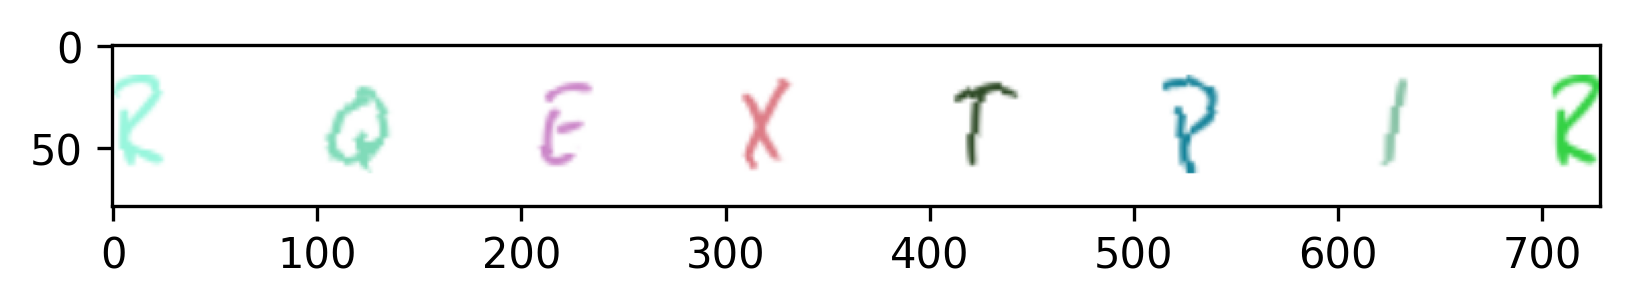

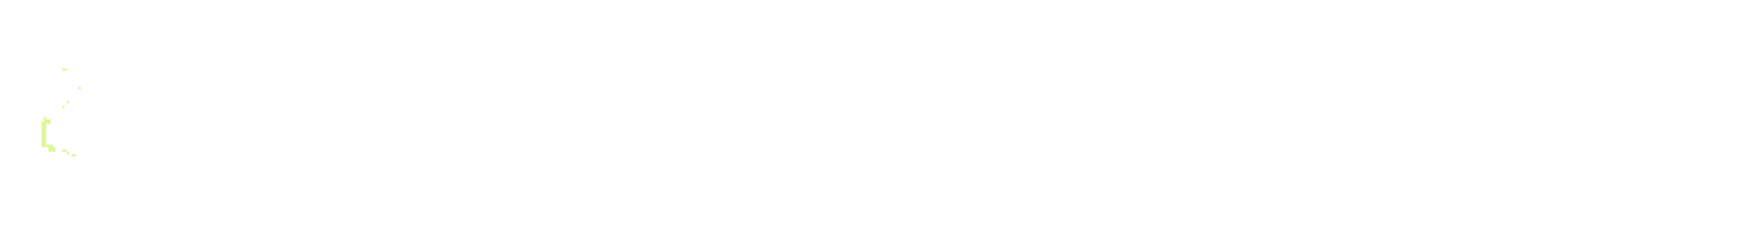

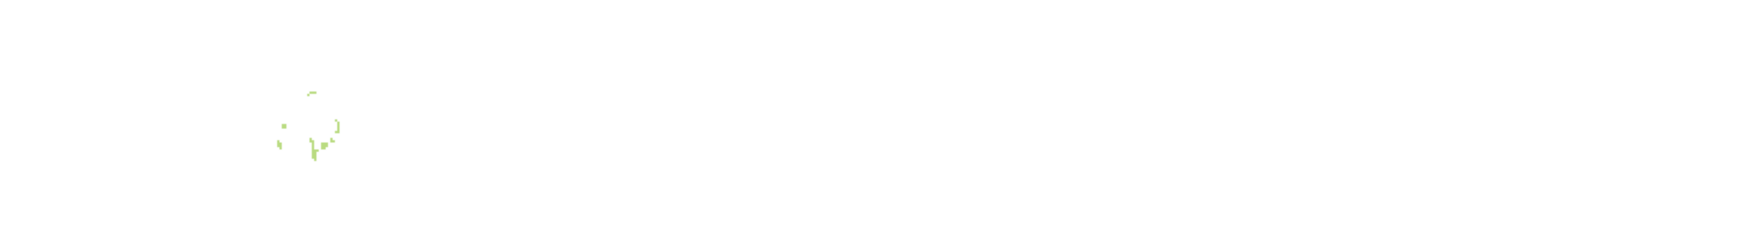

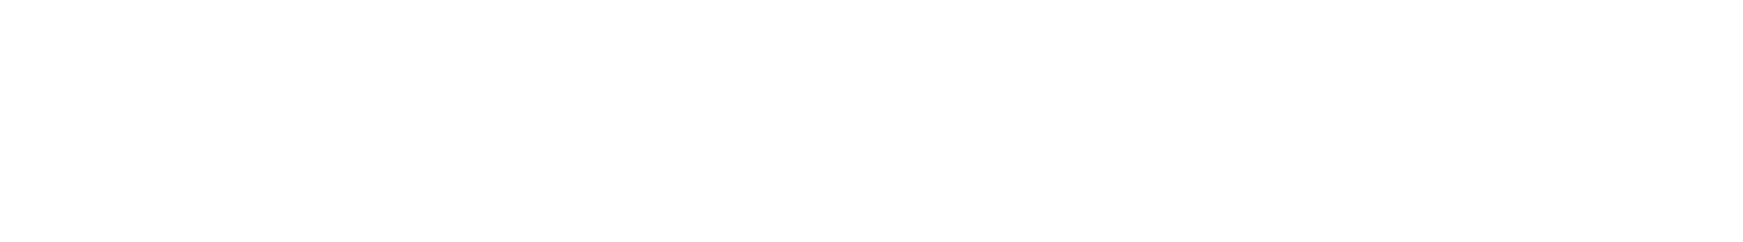

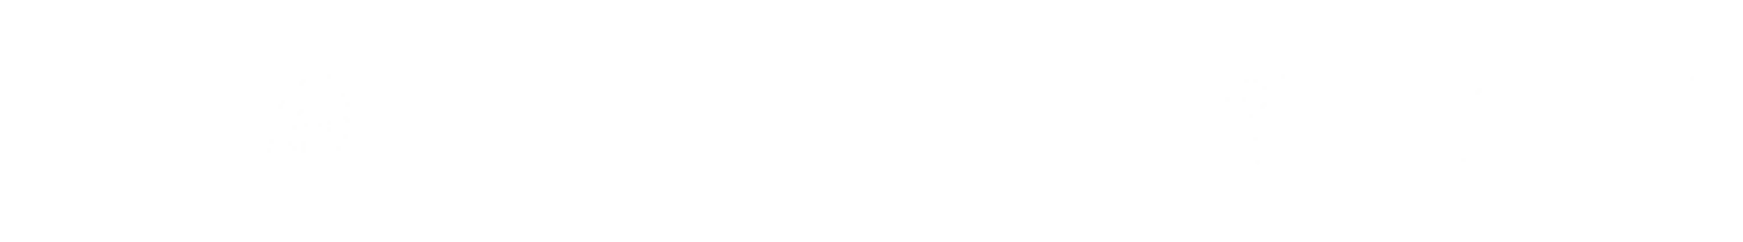

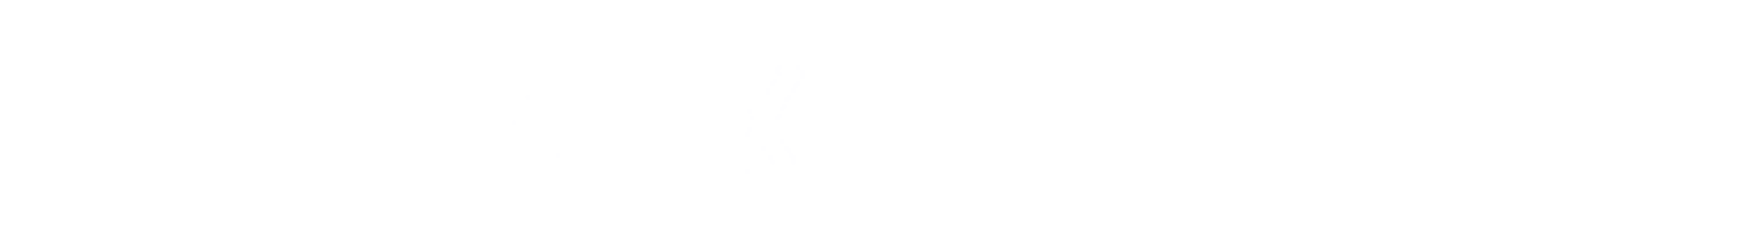

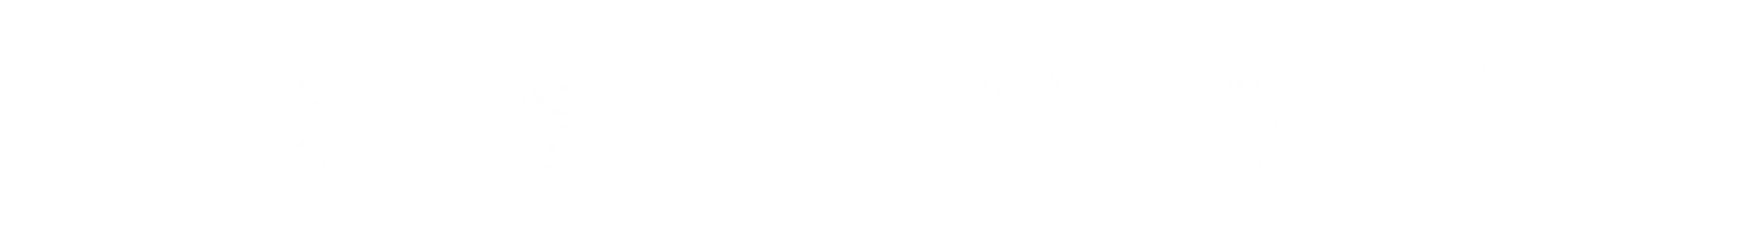

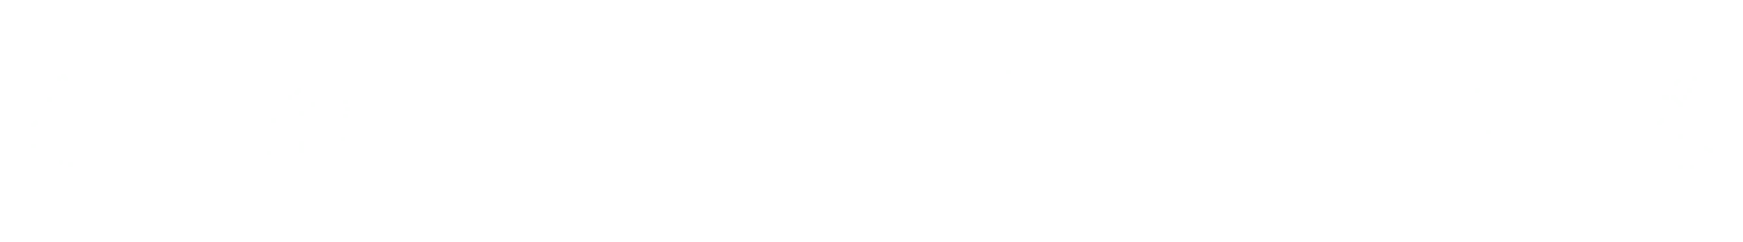

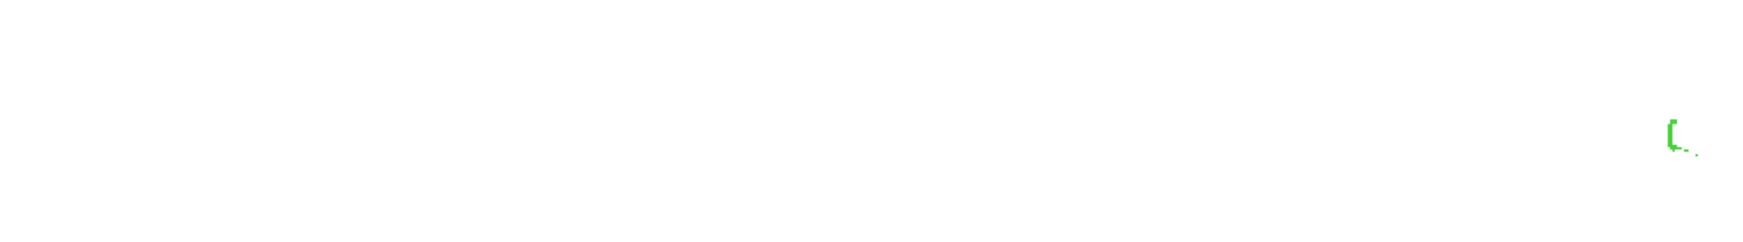

In [53]:
input_folder = './try/'
output_folder = './try/'
os.makedirs(output_folder, exist_ok=True)

background_color = (255, 255, 255)

target_files = {"wtvaivr-0.png"} 

from collections import Counter, defaultdict
from pathlib import Path
from pprint import pprint

def extract_colors(image, background_color):
    """Return the most common colors in the image."""
    return [k for k, _ in Counter(tuple(pixel) for row in image for pixel in row if tuple(pixel) != background_color).most_common(12)]

def sort_colors_by_position(image, colors):
    """Return the pixel colors sorted by their average x position in the image."""
    color_positions = []
    for color in colors:
        y, x = np.where(np.all(image == color, axis=-1))
        avg_x = np.mean(x)
        color_positions.append((avg_x, color))
    color_positions.sort(key=lambda x: x[0])
    return [color for _, color in color_positions]


def extract_colors_v2(image, background_color):
    """Return colors to extract in the image."""
    color_counts = Counter(tuple(pixel) for row in image for pixel in row if not pixels_are_close(background_color, pixel)).most_common(20)
    color_positions = {}
    for color, _ in color_counts:
        _, x = np.where(np.all(image == color, axis=-1))
        avg_x = np.mean(x)
        max_x = max(x)
        min_x = min(x)
        color_positions[color] = (min_x, avg_x, max_x)

    for color, count in color_counts:
        print(list(map(int, color)), count, color_positions[color])

def segment_image(filepath: str):
    """"""
    image = cv2.imread(filepath)

    base_name = Path(filepath).name.split('-')[0]
    # TODO: remove illegal reliance on file name
    n_colors = len(base_name)
    
    # 1. Get n most common colors in the image
    extract_colors_v2(image, background_color)
    colors = extract_colors(image, background_color)
    if len(colors) > n_colors:
        colors = colors[:n_colors]
    
    # 2. Sort colors by x position
    sorted_colors = sort_colors_by_position(image, colors)
    graphic_names = list(base_name)
    name_counter = defaultdict(int)
    
    plt.rcParams['figure.dpi'] = 300
    
    # 3. Filter colors in the image
    for color, name in zip(sorted_colors, graphic_names):
        name_counter[name] += 1
        
        white_background = np.ones_like(image) * 255
        all_x, all_y = np.where(np.all(image == color, axis=-1))
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                if tuple(image[y, x]) == color:
                    white_background[y, x] = image[y, x]

        # cropped_image = white_background[min_x:max_x, min_y:max_y]
        cropped_image = white_background
        
        output_filename = os.path.join(output_folder, f'{base_name}-{name}-{name_counter[name]}.png')
        
        plt.figure(figsize=(cropped_image.shape[1] / 100, cropped_image.shape[0] / 100), dpi=300)
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()



# for file_name in os.listdir(input_folder):
#     if file_name in target_files:  
#         segment_image(os.path.join(input_folder, file_name))
# segment_image("../data/train_cleaned_color_resized/wtvaivr-0.png")
image_name = "rqextpir-0.png" # segmentation sucks so bad for this image
plt.imshow(cv2.imread(os.path.join(IMAGE_FOLDER_PATH, image_name)))
print(image_name)
segment_image(os.path.join(IMAGE_FOLDER_PATH, image_name))